<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_Evaluacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de módulos que se emplean en el notebook

In [1]:
!pip install -q aequitas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Módulos para evaluar rendimiento
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# Módulos para evaluar equidad
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
import aequitas.plot as ap

## Definición de funciones

In [3]:
# Función para mostrar la matriz de confusión
def show_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    plt.ylabel('Diagnóstico real')
    plt.xlabel('Predicción del modelo')

    print('Verdadero negativo: ', cm[0][0])
    print('Falso positivo: ', cm[0][1])
    print('Falso negativo: ', cm[1][0])
    print('Vardadero positivo: ', cm[1][1])


## Preparación de los dataframes

In [4]:
# Fichero con las predicciones del modelo
file_predictions = "/content/drive/MyDrive/TFG/TFG_mejor_modelo_pred.csv"
# Fichero de metadatos de los/las pacientes
file_metadata = "/content/drive/MyDrive/TFG/train.csv"

# Carga del fichero con las predicciones (probabilidades) del modelo
df_predictions = pd.read_csv(file_predictions)

# Carga del fichero con los metadatos de los/las pacientes
df_metadata = pd.read_csv(file_metadata)
# Se cambia el nombre de la columna del diagnóstico real 
# en el dataframe de predicciones
df_predictions.rename(columns = {'target':'target_p'}, inplace = True)

print("Número de registros en fichero de metadatos:", len(df_metadata))
print("Número de registros en fichero de predicciones del conjunto de datos de prueba:", len(df_predictions))

Número de registros en fichero de metadatos: 25331
Número de registros en fichero de predicciones del conjunto de datos de prueba: 3483


In [5]:
# Se combinan (inner join) ambos dataframes por la columna image_name
df_total = pd.merge(df_metadata, df_predictions, on='image_name')

In [6]:
# Se crea una columna con la predicción en binario
df_total['prediction_binary'] = np.where(df_total['prediction'] > 0.5, 1, 0)

In [7]:
# Se comprueba que las etiquetas del fichero de metadados 
# y del fichero de predicciones son la misma 
print(len(df_total[df_total['target']!=df_total['target_p']]))

0


In [8]:
# Se muestran los primeros registros del dataframe combinado
df_total.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,target_p,prediction,prediction_binary
0,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767,0,0.000787,0
1,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767,0,0.033699,0
2,ISIC_0000009,-1,female,30.0,anterior torso,NV,benign,0,8,1022,767,0,0.000856,0
3,ISIC_0000016,-1,female,55.0,anterior torso,NV,benign,0,22,1022,767,0,0.004646,0
4,ISIC_0000072,-1,male,85.0,posterior torso,NV,benign,0,6,1022,767,0,0.433702,0


In [9]:
# Se eliminan columnas innecesarias
df_total = df_total.drop(['patient_id', 'tfrecord', 'width', 
                          'height', 'target_p' ], axis=1)

# Se crean agrupamientos de edades
bins = [0, 15, 30, 50, 65, 100]
df_total['age_group_approx'] = pd.cut(df_total['age_approx'], bins)



In [10]:
# Se muestran los primeros registros del dataframe combinado
df_total.head(10)

,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,prediction,prediction_binary,age_group_approx
0,ISIC_0000001,female,30.0,anterior torso,NV,benign,0,0.000787,0,"(15, 30]"
1,ISIC_0000003,male,30.0,upper extremity,NV,benign,0,0.033699,0,"(15, 30]"
2,ISIC_0000009,female,30.0,anterior torso,NV,benign,0,0.000856,0,"(15, 30]"
3,ISIC_0000016,female,55.0,anterior torso,NV,benign,0,0.004646,0,"(50, 65]"
4,ISIC_0000072,male,85.0,posterior torso,NV,benign,0,0.433702,0,"(65, 100]"
5,ISIC_0000157,male,60.0,upper extremity,MEL,malignant,1,0.896286,1,"(50, 65]"
6,ISIC_0000167,male,40.0,posterior torso,MEL,malignant,1,0.998544,1,"(30, 50]"
7,ISIC_0000172,female,35.0,posterior torso,MEL,malignant,1,0.975155,1,"(30, 50]"
8,ISIC_0000198,male,65.0,lower extremity,NV,benign,0,0.002211,0,"(50, 65]"
9,ISIC_0000199,male,20.0,upper extremity,NV,benign,0,0.046614,0,"(15, 30]"


## Evaluación del rendimiento

In [11]:
# Diagnóstico real
y_true = list(df_total['target'])
# Diagnóstico predicho (probabilidad)
y_pred = list(df_total['prediction'])
# Diagnóstico predicho (binario)
y_pred_binary = list(df_total['prediction_binary'])

### Curva ROC

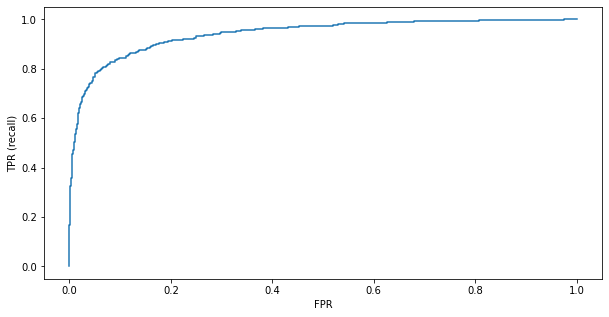

AUC: 0.941


In [12]:
# Calcula la curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr, label="Curva ROC")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.show()

auc = roc_auc_score(y_true, y_pred)
print("AUC: {0:.3f}".format(auc))

### Curva Precisión-Sensibilidad

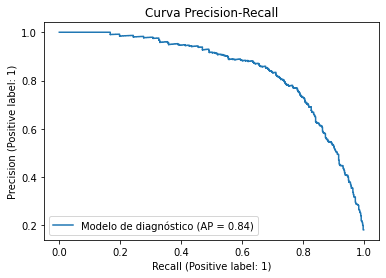

In [13]:
display = PrecisionRecallDisplay.from_predictions(y_true, y_pred, 
                                                  name="Modelo de diagnóstico");
_ = display.ax_.set_title("Curva Precision-Recall");

### Matriz de confusión

Verdadero negativo:  2723
Falso positivo:  139
Falso negativo:  145
Vardadero positivo:  476


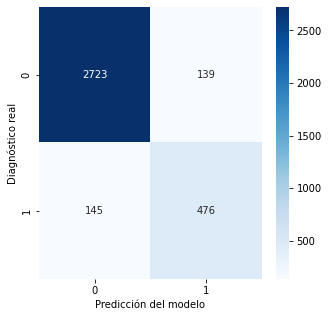

In [14]:
# Matriz de confusión
show_confusion_matrix(y_true, y_pred_binary)

In [15]:
# Métricas precisión, sensibilidad y F1
metrics = precision_recall_fscore_support(y_true, y_pred_binary)
print("Precisión:", round(metrics[0][1],2))
print("Sensibilidad:", round(metrics[1][1],2))
print("Puntuación F1:", round(metrics[2][1],2))

Precisión: 0.77
Sensibilidad: 0.77
Puntuación F1: 0.77


## Evaluación de la equidad

In [16]:
# Se crea el dataframe que se va a utilizar para la evaluación de la equidad
df_fairness = df_total.copy()
# Se necesitan tener las columnas label_value y score
df_fairness = df_fairness.rename(columns={"target": "label_value", "prediction_binary": "score"})
df_fairness["age_group_approx"] = df_fairness["age_group_approx"] .astype(str)
# Se eliminan columnas innecesarias,
df_fairness = df_fairness.drop(['image_name', 'benign_malignant', 'diagnosis', 
                          'age_approx', 'anatom_site_general_challenge',
                          'prediction'], axis=1)
df_fairness.head()

,sex,label_value,score,age_group_approx
0,female,0,0,"(15, 30]"
1,male,0,0,"(15, 30]"
2,female,0,0,"(15, 30]"
3,female,0,0,"(50, 65]"
4,male,0,0,"(65, 100]"


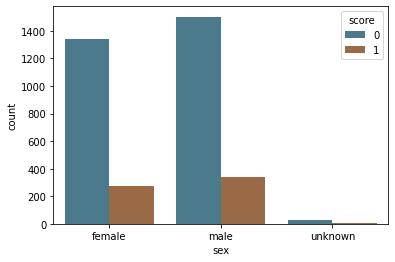

In [17]:
aq_palette = sns.diverging_palette(225, 35, n=2)
by_sex = sns.countplot(x="sex", hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

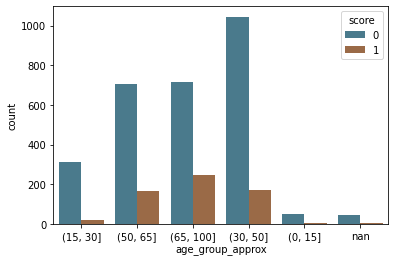

In [18]:
by_age = sns.countplot(x="age_group_approx", 
                       hue="score", 
                       data=df_fairness, 
                       palette=aq_palette)

In [19]:
g = Group()
xtab, _ = g.get_crosstabs(df_fairness)

In [20]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [21]:
xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,ppr,pprev,prev
0,sex,female,0.74,0.95,0.06,0.24,0.05,0.26,0.94,0.76,0.45,0.17,0.18
1,sex,male,0.80,0.95,0.05,0.21,0.05,0.20,0.95,0.79,0.55,0.18,0.18
2,sex,unknown,0.33,0.89,0.07,0.75,0.11,0.67,0.93,0.25,0.01,0.13,0.10
3,age_group_approx,"(0, 15]",0.00,0.91,0.02,1.00,0.09,1.00,0.98,0.00,0.01,0.09,0.02
4,age_group_approx,"(15, 30]",0.53,0.97,0.03,0.47,0.03,0.47,0.97,0.53,0.03,0.06,0.06
5,age_group_approx,"(30, 50]",0.73,0.96,0.05,0.23,0.04,0.27,0.95,0.77,0.28,0.14,0.15
6,age_group_approx,"(50, 65]",0.78,0.95,0.05,0.21,0.05,0.22,0.95,0.79,0.27,0.19,0.20
7,age_group_approx,"(65, 100]",0.81,0.93,0.07,0.20,0.07,0.19,0.93,0.80,0.40,0.26,0.25
8,age_group_approx,nan,0.33,0.93,0.05,0.75,0.07,0.67,0.95,0.25,0.01,0.08,0.06


In [24]:
b = Bias()
bdf = b.get_disparity_predefined_groups(xtab, original_df=df_fairness, 
                                        ref_groups_dict={'sex':'male', 'age_group_approx':'(30, 50]'}, 
                                        alpha=0.05, check_significance=True, 
                                        mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,label_value_significance,score_significance,fdr_disparity,fdr_ref_group_value,fdr_significance,fnr_disparity,fnr_ref_group_value,fnr_significance,for_disparity,for_ref_group_value,for_significance,fpr_disparity,fpr_ref_group_value,fpr_significance,npv_disparity,npv_ref_group_value,npv_significance,ppr_disparity,ppr_ref_group_value,ppr_significance,pprev_disparity,pprev_ref_group_value,pprev_significance,precision_disparity,precision_ref_group_value,precision_significance,tnr_disparity,tnr_ref_group_value,tnr_significance,tpr_disparity,tpr_ref_group_value,tpr_significance
0,0,binary 0/1,615,sex,female,0.735915,0.951054,0.056054,0.237226,0.048946,0.264085,0.943946,0.762774,274,1338,0.445528,0.169975,65,75,1263,209,284,1328,1612,3483,0.176179,False,False,1.125990,male,False,1.297121,male,False,1.238954,male,False,1.038202,male,False,0.988677,male,False,0.813056,male,False,0.928054,male,False,0.966371,male,False,0.998110,male,False,0.924044,male,False
1,0,binary 0/1,615,sex,male,0.796407,0.952855,0.045243,0.210682,0.047145,0.203593,0.954757,0.789318,337,1503,0.547967,0.183152,71,68,1435,266,334,1506,1840,3483,0.181522,False,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False,1.000000,male,False
2,0,binary 0/1,615,sex,unknown,0.333333,0.892857,0.074074,0.750000,0.107143,0.666667,0.925926,0.250000,4,27,0.006504,0.129032,3,2,25,1,3,28,31,3483,0.096774,False,False,3.559859,male,True,3.274510,male,False,1.637255,male,False,2.272636,male,True,0.969803,male,False,0.011869,male,False,0.704508,male,False,0.316729,male,True,0.937033,male,True,0.418546,male,False
3,0,binary 0/1,615,age_group_approx,"(0, 15]",0.000000,0.909091,0.019608,1.000000,0.090909,1.000000,0.980392,0.000000,5,51,0.008130,0.089286,5,1,50,0,1,55,56,3483,0.017857,True,False,4.435897,"(30, 50]",True,3.734694,"(30, 50]",False,0.418167,"(30, 50]",False,2.412587,"(30, 50]",True,1.028624,"(30, 50]",False,0.028902,"(30, 50]",False,0.628613,"(30, 50]",False,0.000000,"(30, 50]",True,0.944688,"(30, 50]",True,0.000000,"(30, 50]",False
4,0,binary 0/1,615,age_group_approx,"(15, 30]",0.526316,0.970968,0.029032,0.473684,0.029032,0.473684,0.970968,0.526316,19,310,0.030894,0.057751,9,9,301,10,19,310,329,3483,0.057751,True,True,2.101215,"(30, 50]",False,1.769066,"(30, 50]",False,0.619157,"(30, 50]",False,0.770471,"(30, 50]",False,1.018736,"(30, 50]",False,0.109827,"(30, 50]",True,0.406592,"(30, 50]",True,0.679497,"(30, 50]",False,1.008988,"(30, 50]",False,0.718775,"(30, 50]",False
5,0,binary 0/1,615,age_group_approx,"(30, 50]",0.732240,0.962319,0.046890,0.225434,0.037681,0.267760,0.953110,0.774566,173,1045,0.281301,0.142036,39,49,996,134,183,1035,1218,3483,0.150246,False,False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False,1.000000,"(30, 50]",False
6,0,binary 0/1,615,age_group_approx,"(50, 65]",0.782353,0.950071,0.052632,0.208333,0.049929,0.217647,0.947368,0.791667,168,703,0.273171,0.192882,35,37,666,133,170,701,871,3483,0.195178,True,True,0.924145,"(30, 50]",False,0.812845,"(30, 50]",False,1.122449,"(30, 50]",False,1.325030,"(30, 50]",False,0.993976,"(30, 50]",False,0.971098,"(30, 50]",True,1.357977,"(30, 50]",True,1.022077,"(30, 50]",False,0.987273,"(30, 50]",False,1.068437,"(30, 50]",False
7,0,binary 0/1,615,age_group_approx,"(65, 100]",0.808163,0.932961,0.065734,0.195122,0.067039,0.191837,0.934266,0.804878,246,715,0.400000,0.255983,48,47,668,198,245,716,961,3483,0.254943,True,True,0.865541,"(30, 50]",False,0.716451,"(30, 50]",False,1.401884,"(30, 50]",False,1.779115,"(30, 50]",False,0.9

In [25]:
# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +
     b.list_disparities(bdf) + b.list_significance(bdf)].style

,attribute_name,attribute_value,fdr_disparity,fnr_disparity,for_disparity,fpr_disparity,npv_disparity,ppr_disparity,pprev_disparity,precision_disparity,tnr_disparity,tpr_disparity,label_value_significance,score_significance,fdr_significance,fnr_significance,for_significance,fpr_significance,npv_significance,ppr_significance,pprev_significance,precision_significance,tnr_significance,tpr_significance
0,sex,female,1.125990,1.297121,1.238954,1.038202,0.988677,0.813056,0.928054,0.966371,0.998110,0.924044,False,False,False,False,False,False,False,False,False,False,False,False
1,sex,male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
2,sex,unknown,3.559859,3.274510,1.637255,2.272636,0.969803,0.011869,0.704508,0.316729,0.937033,0.418546,False,False,True,False,False,True,False,False,False,True,True,False
3,age_group_approx,"(0, 15]",4.435897,3.734694,0.418167,2.412587,1.028624,0.028902,0.628613,0.000000,0.944688,0.000000,True,False,True,False,False,True,False,False,False,True,True,False
4,age_group_approx,"(15, 30]",2.101215,1.769066,0.619157,0.770471,1.018736,0.109827,0.406592,0.679497,1.008988,0.718775,True,True,False,False,False,False,False,True,True,False,False,False
5,age_group_approx,"(30, 50]",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,False,False,False,False,False,False,False,False,False,False,False,False
6,age_group_approx,"(50, 65]",0.924145,0.812845,1.122449,1.325030,0.993976,0.971098,1.357977,1.022077,0.987273,1.068437,True,True,False,False,False,False,False,True,True,False,False,False
7,age_group_approx,"(65, 100]",0.865541,0.716451,1.401884,1.779115,0.980229,1.421965,1.802241,1.039134,0.969492,1.103686,True,True,False,False,False,False,False,True,True,False,False,False
8,age_group_approx,nan,3.326923,2.489796,0.969388,1.769231,1.001506,0.023121,0.586705,0.322761,0.969880,0.455224,False,False,True,False,False,True,False,False,False,True,True,False


In [26]:
metrics = ['fpr','fdr']
disparity_tolerance = 1.25

In [27]:
ap.summary(bdf, metrics, fairness_threshold = disparity_tolerance)

alt.VConcatChart(...)